# Data Augmentation for Dataset Balancing

Ce notebook permet d'augmenter votre dataset en appliquant 6 types d'augmentations pour équilibrer les classes.

## 1. Imports

In [43]:
import os  # fournit les fonctions pour interagir avec le système de fichiers
from PIL import Image, ImageOps  # permet de manipuler les images et d'appliquer les transformations
import random  # utilisé pour tirer des transformations aléatoires
import matplotlib.pyplot as plt  # sert à afficher les résultats graphiques
import numpy as np  # fournit des structures de données et opérations numériques
from tqdm import tqdm  # affiche des barres de progression pendant les boucles

## 2. Fonctions d'Augmentation

Définition des 6 types d'augmentation géométrique.

In [44]:
# Définit une fonction pour retourner horizontalement l'image fournie
def flip_image(image):
    # Utilise ImageOps.mirror pour renverser l'image horizontalement
    return ImageOps.mirror(image)


# Définit une fonction pour faire pivoter l'image d'un angle aléatoire parmi 90, 180 ou 270 degrés
def rotate_image(image):
    # Retourne l'image tournée en utilisant l'angle choisi aléatoirement
    return image.rotate(random.choice([90, 180, 270]))


# Définit une fonction pour appliquer une inclinaison horizontale (skew)
def skew_image(image):
    # Récupère les dimensions de l'image
    width, height = image.size
    # Calcule le décalage horizontal aléatoire
    xshift = width * random.uniform(-0.1, 0.1)
    # Calcule la nouvelle largeur après transformation
    new_width = width + abs(xshift)
    # Applique la transformation affine pour l'inclinaison
    image = image.transform((int(new_width), height),
                            Image.AFFINE,
                            (1, xshift / width, 0, 0, 1, 0),
                            Image.BICUBIC)
    # Retourne l'image transformée
    return image


# Définit une fonction pour effectuer un cisaillement (shear) de l'image
def shear_image(image):
    # Récupère les dimensions originales
    width, height = image.size
    # Détermine le coefficient de cisaillement aléatoire
    m = random.uniform(-0.2, 0.2)
    # Calcule le déplacement horizontal basé sur le cisaillement
    xshift = abs(m) * width
    # Calcule la largeur totale après transformation
    new_width = width + int(round(xshift))
    # Applique la transformation affine de cisaillement
    image = image.transform((new_width, height),
                            Image.AFFINE,
                            (1, m, -xshift if m > 0 else 0, 0, 1, 0),
                            Image.BICUBIC)
    # Retourne l'image cisaillée
    return image


# Définit une fonction pour recadrer aléatoirement l'image
def crop_image(image):
    # Récupère les dimensions de l'image
    width, height = image.size
    # Détermine les marges de recadrage aléatoires
    left = random.randint(0, width // 8)
    top = random.randint(0, height // 8)
    right = random.randint(7 * width // 8, width)
    bottom = random.randint(7 * height // 8, height)
    # Effectue et retourne le recadrage
    return image.crop((left, top, right, bottom))


# Définit une fonction pour distordre l'image en perspective
def distort_image(image):
    # Récupère les dimensions de l'image
    width, height = image.size
    # Calcule les nouveaux points d'origine pour la distorsion
    coeffs = find_coeffs(
        [(random.uniform(0, width * 0.1),
          random.uniform(0, height * 0.1)),
         (width - random.uniform(0, width * 0.1),
          random.uniform(0, height * 0.1)),
         (width - random.uniform(0, width * 0.1),
          height - random.uniform(0, height * 0.1)),
         (random.uniform(0, width * 0.1),
          height - random.uniform(0, height * 0.1))],
        [(0, 0), (width, 0), (width, height), (0, height)]
    )
    # Applique la transformation en perspective et retourne l'image
    return image.transform((width, height),
                           Image.PERSPECTIVE,
                           coeffs,
                           Image.BICUBIC)


# Définit une fonction pour calculer les coefficients nécessaires à la transformation perspective
def find_coeffs(pa, pb):
    # Initialise la matrice pour résoudre le système linéaire
    matrix = []
    # Remplit la matrice avec les équations pour les coefficients
    for p1, p2 in zip(pa, pb):
        matrix.append([p1[0], p1[1], 1, 0, 0, 0,
                       -p2[0] * p1[0], -p2[0] * p1[1]])
        matrix.append([0, 0, 0, p1[0], p1[1], 1,
                       -p2[1] * p1[0], -p2[1] * p1[1]])

    # Convertit la matrice en array numpy
    A = np.matrix(matrix, dtype=float)
    # Prépare le vecteur B à partir des points cibles
    B = np.array(pb).reshape(8)

    # Résout le système pour obtenir les coefficients
    res = np.dot(np.linalg.inv(A.T * A) * A.T, B)
    # Retourne les coefficients sous forme de tableau à 1 dimension
    return np.array(res).reshape(8)

# Indique que les fonctions d'augmentation sont prêtes à être utilisées
print("Fonctions d'augmentation définies")

Fonctions d'augmentation définies


## 3. Visualisation des Augmentations

Visualisons l'effet de chaque augmentation sur une image d'exemple.

In [45]:
# Chemin vers une image d'exemple
EXAMPLE_IMAGE = "../Grape/Grape_spot/image (8).JPG"

if not os.path.exists(EXAMPLE_IMAGE):
    print(f"Image non trouvée: {EXAMPLE_IMAGE}")
else:
    print(f"Image trouvée: {EXAMPLE_IMAGE}")

Image trouvée: ../Grape/Grape_spot/image (8).JPG


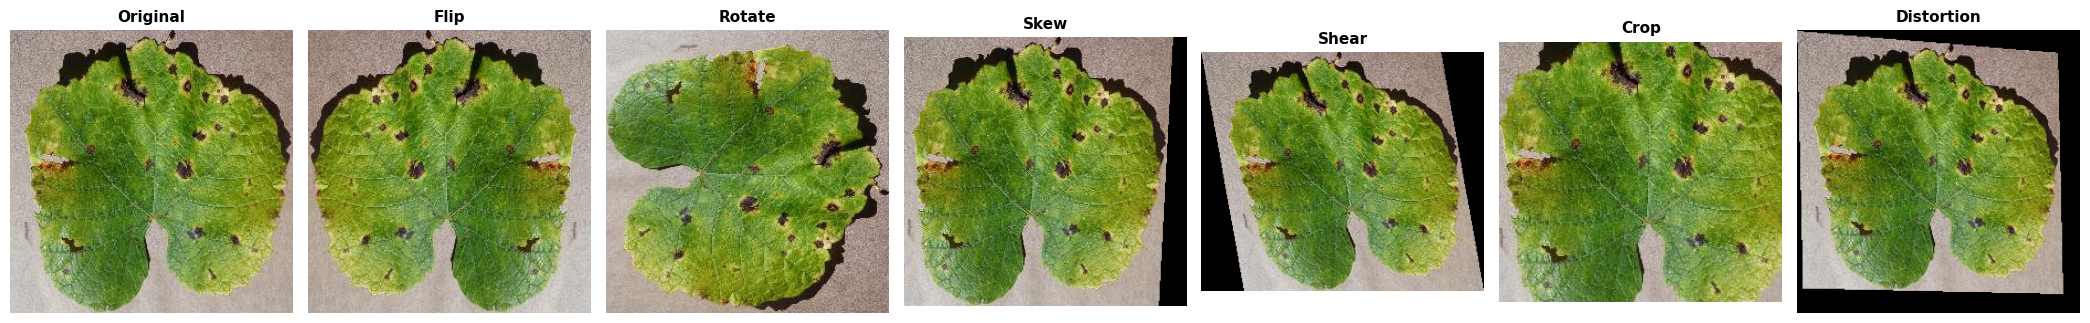

In [46]:
# Définit une fonction pour afficher l'image originale et ses augmentations
def display_augmentations(image_path):
    # Ouvre l'image source à partir du chemin fourni
    image = Image.open(image_path)

    # Crée une liste des paires nom de transformation et image transformée
    augmentations = [
        ('Original', image),
        ('Flip', flip_image(image)),
        ('Rotate', rotate_image(image)),
        ('Skew', skew_image(image)),
        ('Shear', shear_image(image)),
        ('Crop', crop_image(image)),
        ('Distortion', distort_image(image)),
    ]

    # Crée une figure avec 7 sous-graphes côte à côte
    fig, axes = plt.subplots(1, 7, figsize=(21, 4))

    # Parcourt chaque axe et affiche l'image correspondante
    for ax, (name, aug_img) in zip(axes, augmentations):
        ax.imshow(aug_img)
        ax.set_title(name, fontsize=11, fontweight='bold')
        ax.axis('off')

    # Ajuste la mise en page pour éviter les chevauchements
    plt.tight_layout()
    plt.show()

# Affiche les augmentations si l'image d'exemple existe
if os.path.exists(EXAMPLE_IMAGE):
    display_augmentations(EXAMPLE_IMAGE)

## 4. Analyse du Dataset Actuel

In [51]:
# Analyse le dataset et retourne les statistiques par classe.
def analyze_dataset(directory):
    """
    Parcourt les sous-dossiers de `directory` pour dresser un bilan des types de plantes
    et maladies identifiées dans la structure {plant_type}_{disease}. Chaque sous-dossier
    doit contenir des images JPG.

    Pour chaque dossier valide :
    * Sépare le nom en type de plante et maladie.
    * Compte le nombre d'images dont l'extension est .jpg ou .JPG.
    * Construit un dictionnaire imbriqué {plant_type: {disease: count}}.

    Les dossiers dont le nom ne respecte pas le format attendu sont ignorés avec un avertissement.
    Cette fonction permet de savoir rapidement quelles classes sont minoritaires avant toute augmentation.

    Args:
        directory (str): Répertoire racine contenant les sous-dossiers {plant_type}_{disease}.

    Returns:
        dict: Statistiques structurées par type de plante, puis par maladie avec les totaux d'images.
    """
    # Initialise un dictionnaire pour stocker les types de plantes et leurs maladies
    plant_types = {}
    # Parcourt chaque sous-répertoire dans le répertoire fourni
    for subdir in os.listdir(directory):
        # Construit le chemin complet du sous-répertoire
        path = os.path.join(directory, subdir)
        # Ne traite que les dossiers
        if os.path.isdir(path):
            try:
                # Sépare le nom du dossier en type de plante et maladie
                plant_type, disease = subdir.split('_', 1)
                # Crée une entrée pour le type de plante si elle n'existe pas
                if plant_type not in plant_types:
                    plant_types[plant_type] = {}
                # Compte le nombre d'images JPG dans le dossier
                num_images = len([f for f in os.listdir(path)
                                 if f.lower().endswith(('.jpg'))])
                # Stocke le nombre d'images pour cette maladie
                plant_types[plant_type][disease] = num_images
            except ValueError:
                # Ignore les dossiers au format incorrect
                print(f"Dossier ignoré: {subdir} (format incorrect)")
    # Retourne les statistiques construites
    return plant_types

DATA_DIR = "../Apple"

if os.path.exists(DATA_DIR):
    print("=== ANALYSE DU DATASET ACTUEL ===")
    categories = analyze_dataset(DATA_DIR)

    for plant_type, diseases in categories.items():
        print(f"\n{plant_type}:")
        for disease, count in diseases.items():
            print(f"  {disease}: {count} images")
else:
    print(f"Dossier non trouvé: {DATA_DIR}")

=== ANALYSE DU DATASET ACTUEL ===

Apple:
  scab: 629 images
  healthy: 1640 images
  rust: 275 images
  Black_rot: 620 images


## 5. Équilibrage du Dataset

Cette fonction augmente automatiquement les classes minoritaires pour atteindre le nombre d'images de la classe majoritaire.

In [52]:
# Define a function to apply random augmentations to an image and track the results.
def augment_image(image_path, output_dir, num_augmentations_needed=1):
    """
    Applique un ensemble d'augmentations aléatoires définies sur une image
    donnée et sauvegarde les résultats.

    Args:
        image_path (str): Chemin vers l'image source à augmenter.
        output_dir (str): Répertoire cible où enregistrer les images augmentées.
        num_augmentations_needed (int): Nombre maximal d'augmentations à générer.
            Des fonctions d'augmentation prédéfinies sont choisies aléatoirement parmi
            un ensemble fixe pour garantir de la diversité.

    Returns:
        int: Nombre d'images augmentées effectivement créées.
    """
    # Open the provided image file to prepare it for augmentations.
    image = Image.open(image_path)
    # Extract the base filename to reuse in naming augmented outputs.
    base_name = os.path.splitext(os.path.basename(image_path))[0]

    # List the available augmentation techniques with identifiers.
    augmentations = [
        ('Flip', flip_image),
        ('Rotate', rotate_image),
        ('Skew', skew_image),
        ('Shear', shear_image),
        ('Crop', crop_image),
        ('Distortion', distort_image),
    ]

    # Choose a subset of augmentations randomly based on the requested count.
    selected_augmentations = random.sample(
        augmentations,
        min(num_augmentations_needed, len(augmentations))
    )

    # Track how many augmentations were successfully generated.
    augmented_count = 0
    # Iterate through each selected augmentation until the quota is met.
    for aug_name, aug_func in selected_augmentations:
        if augmented_count >= num_augmentations_needed:
            break
        try:
            # Apply the augmentation function to the image.
            augmented_image = aug_func(image)
            # Construct a filename including the augmentation name and randomness.
            augmented_image_path = os.path.join(
                output_dir,
                f"{base_name}_{aug_name}_{random.randint(1000, 9999)}.JPG"
            )
            # Save the newly created augmented image to disk.
            augmented_image.save(augmented_image_path)
            augmented_count += 1
        except Exception as e:
            # Report any errors that occur during augmentation without stopping the loop.
            print(f"  Erreur avec {aug_name}: {e}")

    # Return the total number of images that were produced.
    return augmented_count


# Define a function that balances the dataset by generating new images for minority classes.
def balance_dataset(directory, dry_run=False):
    """
    Analyse les classes du dataset et équilibre le nombre d'exemples par maladie
    via des augmentations.

    Le script inspecte les sous-dossiers structurés par type de plante et maladie.
    Pour chaque maladie minoritaire, il crée des images supplémentaires en
    utilisant `augment_image` jusqu'à ce que chaque classe ait autant d'exemples
    que la classe la plus fournie. Il gère aussi un mode "dry run" pour mesurer
    l'effort sans écrire de fichiers.

    Args:
        directory (str): Répertoire racine contenant les sous-répertoires
            nommés selon le schéma {plant_type}_{disease}.
        dry_run (bool): Si True, affiche uniquement les actions sans générer
            d'images ni modifier le disque.
    """
    # Announce the start of the analysis process.
    print("=== ANALYSE INITIALE ===")
    # Use a helper to analyze current dataset composition.
    categories = analyze_dataset(directory)

    # Exit early if no categories are detected.
    if not categories:
        print("Aucune catégorie trouvée!")
        return

    # Loop through each plant type and its disease-specific counts.
    for plant_type, diseases in categories.items():
        # Announce balancing steps for the current plant type.
        print(f"\n=== ÉQUILIBRAGE DE {plant_type.upper()} ===")

        # Determine the maximum count across diseases for this plant type.
        max_images = max(diseases.values())
        target_images = max_images

        # Inform the user of the current target per class.
        print(f"Cible d'équilibrage: {target_images} images par classe")

        # Iterate through each disease and its current image count.
        for disease, count in diseases.items():
            path = os.path.join(directory, f"{plant_type}_{disease}")
            # Report the existing image count for the current disease.
            print(f"\n{plant_type}_{disease}: {count} images")

            # Identify if more augmentations are needed.
            if count < target_images:
                needed = target_images - count
                print(f"  Besoin de {needed} images supplémentaires")

                # Handle dry-run mode by skipping actual generation.
                if dry_run:
                    print(f"  [DRY RUN] Générerait {needed} nouvelles images")
                    continue

                # Collect original images that have not already been augmented.
                original_images = [
                    os.path.join(path, file)
                    for file in os.listdir(path)
                    if file.lower().endswith(('.jpg'))
                    and not any(aug in file for aug in
                                ['_Flip', '_Rotate', '_Skew',
                                    '_Crop', '_Shear', '_Distortion'])
                ]

                # Log if no originals are available for augmentation.
                if not original_images:
                    print(f"  Aucune image originale trouvée dans {path}")
                    continue

                # Start generating the required augmentations.
                generated = 0
                pbar = tqdm(total=needed, desc="  Génération")

                # Continue generating until the requirement is satisfied.
                while generated < needed:
                    # Choose a random base image to augment.
                    image_path = random.choice(original_images)
                    remaining = needed - generated
                    # Limit the number of augmentations created per iteration.
                    augmentations_to_create = min(3, remaining)

                    try:
                        # Attempt to create augmentations for the selected image.
                        created = augment_image(image_path, path,
                                                augmentations_to_create)
                        generated += created
                        pbar.update(created)
                    except Exception as e:
                        # Report any generation errors encountered.
                        print(f"\n  Erreur: {e}")

                # Close the progress indicator and summarize the work.
                pbar.close()
                print(f" {generated} nouvelles images créées")
            else:
                # Notify that no action is needed for already balanced diseases.
                print(" Déjà équilibré")

    # After processing, print a summary of the final dataset state.
    print("\n=== ANALYSE FINALE ===")
    final_categories = analyze_dataset(directory)
    for plant_type, diseases in final_categories.items():
        print(f"\n{plant_type}:")
        for disease, count in diseases.items():
            print(f"  {disease}: {count} images")

# Confirm that the balancing logic has been defined.
print("✓ Fonction d'équilibrage définie")

✓ Fonction d'équilibrage définie


## 6. Exécution de l'Équilibrage

### Option A: Simulation (Dry Run)

In [53]:
# Exécuter en mode simulation pour voir ce qui serait fait
if os.path.exists(DATA_DIR):
    balance_dataset(DATA_DIR, dry_run=True)
else:
    print(f"Dossier non trouvé: {DATA_DIR}")

=== ANALYSE INITIALE ===

=== ÉQUILIBRAGE DE APPLE ===
Cible d'équilibrage: 1640 images par classe

Apple_scab: 629 images
  Besoin de 1011 images supplémentaires
  [DRY RUN] Générerait 1011 nouvelles images

Apple_healthy: 1640 images
 Déjà équilibré

Apple_rust: 275 images
  Besoin de 1365 images supplémentaires
  [DRY RUN] Générerait 1365 nouvelles images

Apple_Black_rot: 620 images
  Besoin de 1020 images supplémentaires
  [DRY RUN] Générerait 1020 nouvelles images

=== ANALYSE FINALE ===

Apple:
  scab: 629 images
  healthy: 1640 images
  rust: 275 images
  Black_rot: 620 images


### Option B: Exécution Réelle

Attention: Ceci va créer de nouvelles images dans votre dataset!

In [54]:

stats_before = analyze_dataset(DATA_DIR)

# Exécuter réellement l'équilibrage
if os.path.exists(DATA_DIR):
    balance_dataset(DATA_DIR, dry_run=False)
else:
    print(f"Dossier non trouvé: {DATA_DIR}")

=== ANALYSE INITIALE ===

=== ÉQUILIBRAGE DE APPLE ===
Cible d'équilibrage: 1640 images par classe

Apple_scab: 629 images
  Besoin de 1011 images supplémentaires


  Génération: 100%|██████████| 1011/1011 [00:07<00:00, 132.06it/s]


 1011 nouvelles images créées

Apple_healthy: 1640 images
 Déjà équilibré

Apple_rust: 275 images
  Besoin de 1365 images supplémentaires


  Génération: 100%|██████████| 1365/1365 [00:09<00:00, 148.27it/s]


 1365 nouvelles images créées

Apple_Black_rot: 620 images
  Besoin de 1020 images supplémentaires


  Génération: 100%|██████████| 1020/1020 [00:07<00:00, 130.67it/s]

 1020 nouvelles images créées

=== ANALYSE FINALE ===

Apple:
  scab: 1640 images
  healthy: 1640 images
  rust: 1640 images
  Black_rot: 1640 images


## 7. Visualisation Avant/Après

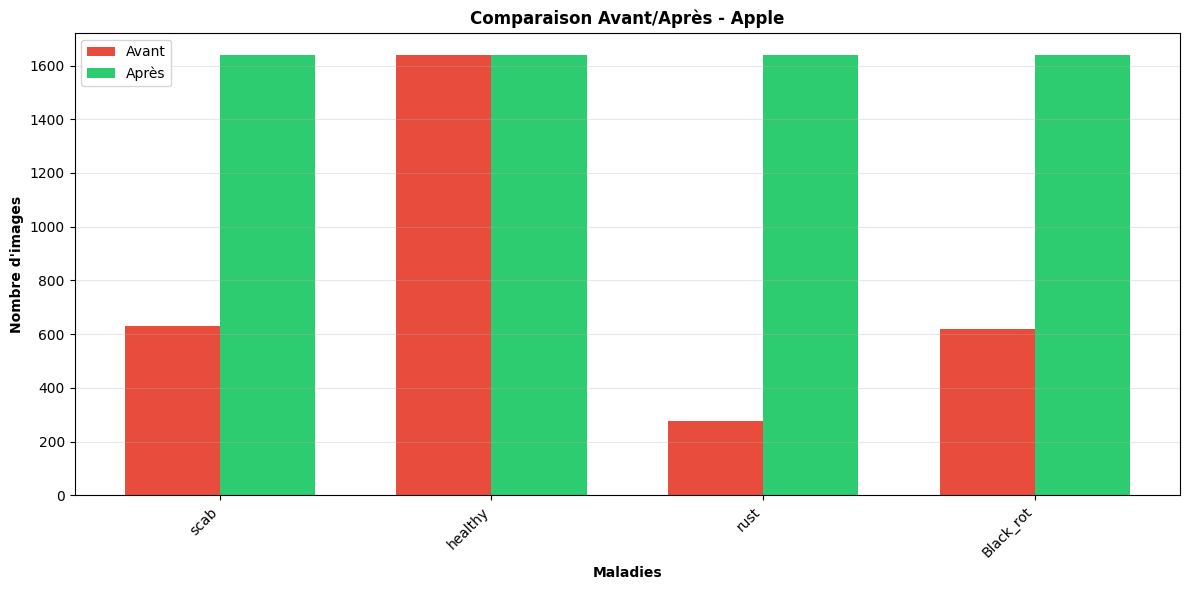

In [55]:
# Define a function that creates visual comparisons between pre- and post-augmentation statistics.
def plot_before_after_comparison(stats_before, stats_after):
       """
       Compare les statistiques avant et après l'augmentation.
       """
       # Parcourt chaque type de plante présent dans les statistiques initiales.
       for plant_type in stats_before.keys():
              # Récupère la liste des maladies pour ce type de plante.
              diseases = list(stats_before[plant_type].keys())
              # Récupère les comptes avant augmentation pour chaque maladie.
              before_counts = [stats_before[plant_type][d] for d in diseases]
              # Récupère les comptes après augmentation pour chaque maladie.
              after_counts = [stats_after[plant_type][d] for d in diseases]

              # Génère une séquence d'indices pour positionner les barres.
              x = np.arange(len(diseases))
              # Définit la largeur des barres côte à côte.
              width = 0.35

              # Prépare une figure et un axe pour la visualisation.
              fig, ax = plt.subplots(figsize=(12, 6))
              # Trace les barres représentant les comptes avant augmentation.
              ax.bar(x - width/2, before_counts, width, label='Avant',
                        color='#e74c3c')
              # Trace les barres représentant les comptes après augmentation.
              ax.bar(x + width/2, after_counts, width, label='Après',
                        color='#2ecc71')

              # Configure le label de l'axe des abscisses.
              ax.set_xlabel('Maladies', fontweight='bold')
              # Configure le label de l'axe des ordonnées.
              ax.set_ylabel("Nombre d'images", fontweight='bold')
              # Ajoute un titre contextualisé pour le type de plante.
              ax.set_title(f'Comparaison Avant/Après - {plant_type}',
                                    fontweight='bold')
              # Définit les positions des marques de graduation sur l'axe des x.
              ax.set_xticks(x)
              # Définit les étiquettes des maladies avec rotation pour lisibilité.
              ax.set_xticklabels(diseases, rotation=45, ha='right')
              # Ajoute une légende pour distinguer les deux séries.
              ax.legend()
              # Ajoute une grille horizontale discrète.
              ax.grid(axis='y', alpha=0.3)

              # Ajuste la mise en page pour éviter les chevauchements.
              plt.tight_layout()
              # Affiche la figure résultante.
              plt.show()

# Calcule les statistiques après équilibrage pour comparaison.
stats_after = analyze_dataset(DATA_DIR)
# Appelle la fonction de comparaison pour tracer les différences.
plot_before_after_comparison(stats_before, stats_after)